In [1]:
import os
import nucml.datasets as nuc_data
import logging
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv

Monkey patch load_exfor method for most recent pandas (I am running a downgraded pandas [1.3.5]for compatability, <font color='red'>we currently don't need this</font>)

In [4]:
from sklearn.model_selection import train_test_split
import nucml.processing as nuc_proc

def custom_load_exfor(log=False, low_en=False, basic=-1, num=False, frac=0.1, mode="neutrons", scaling_type="standard",
    scaler_dir=None, filters=False, max_en=2.0E7, mt_coding="one_hot", scale_energy=False, projectile_coding="one_hot",
    normalize=True, pedro=False, pedro_v2=False):
    """Loads the EXFOR dataset in its varius forms. This function helps load ML-ready EXFOR datasets
    for different particle induce reactions or all of them.

    Args:
        log (bool, optional): If True, the log of the Energy and Cross Section is taken. Defaults to False.
        low_en (bool, optional): If True, an upper limit in energy is applied given by the max_en argument. Defaults to False.
        basic (int, optional): Indicates how many features to load. -1 means all avaliable features. Defaults to -1.
        num (bool, optional): If True, only numerical and relevant categorical features are loaded. Defaults to False.
        frac (float, optional): Fraction of the dataset for test set. Defaults to 0.1.
        mode (str, optional): Dataset to load. Options include neutrons, gammas, and protons. Defaults to "neutrons".
        scaling_type (str, optional): Type of scaler to use for normalizing the dataset. Defaults to "standard".
        scaler_dir (str, optional): Directory in which to store the trained scaler. Defaults to None.
        filters (bool, optional): If True, a variety of filters are applied that help discard irregular data. Defaults to False.
        max_en (float, optional): Maximum energy threshold by which the dataset is filtered. Defaults to 2.0E7.
        mt_coding (str, optional): Method used to process the MT reaction channel codes. Defaults to "one_hot".
        scale_energy (bool, optional): If True, the energy will be normalized along with all other features. Defaults to False.
        projectile_coding (str, optional): Method used to process the type of projectile. Defaults to "one_hot".
        pedro (bool, optional): Personal settings. Defaults to False.

    Raises:
        FileNotFoundError: If mode is all and one of the files is missing.
        FileNotFoundError: If the selected mode file does not exist.

    Returns:
        DataFrame: Only returns one dataset if num=False.
        DataFrames: Multiple dataframes and objects if num=True.
    """
    if pedro:
        log = low_en = num = filters = normalize = True
    if pedro_v2:
        log = low_en = num = filters = True
    if mode not in nuc_data.supported_modes:
        return logging.error("Specified MODE not supported. Supported modes include: {}".format(' '.join([str(v) for v in nuc_data.supported_modes])))
    if mt_coding not in nuc_data.supported_mt_coding:
        return logging.error("Specified mt_coding not supported. Supported codings include: {}".format(' '.join([str(v) for v in nuc_data.supported_mt_coding])))

    logging.info(" MODE: {}".format(mode))
    logging.info(" LOW ENERGY: {}".format(low_en))
    logging.info(" LOG: {}".format(log))
    logging.info(" BASIC: {}".format(basic))
    # logging.info(" SCALER: {}".format(scaling_type.upper()))

    if mode == "all":
        neutrons_datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + "neutrons" + '\\EXFOR_' + "neutrons" + '_MF3_AME_no_RawNaN.csv')
        # neutrons_datapath = 'C:\\Users\\Pedro\\Desktop\\ML_Nuclear_Data\\EXFOR\\CSV_Files\\EXFOR_' + "neutrons" + '\\EXFOR_' + "neutrons" + '_MF3_AME_no_RawNaN.csv'
        protons_datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + "protons" + '\\EXFOR_' + "protons" + '_MF3_AME_no_RawNaN.csv')
        alphas_datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + "alphas" + '\\EXFOR_' + "alphas" + '_MF3_AME_no_RawNaN.csv')
        deuterons_datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + "deuterons" + '\\EXFOR_' + "deuterons" + '_MF3_AME_no_RawNaN.csv')
        gammas_datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + "gammas" + '\\EXFOR_' + "gammas" + '_MF3_AME_no_RawNaN.csv')
        helions_datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + "helions" + '\\EXFOR_' + "helions" + '_MF3_AME_no_RawNaN.csv')
        all_datapaths = [neutrons_datapath, protons_datapath, alphas_datapath, deuterons_datapath, gammas_datapath, helions_datapath]
        if gen_utils.check_if_files_exist(all_datapaths):
            df = pd.read_csv(neutrons_datapath, dtype=nuc_data.dtype_exfor).dropna()
            protons = pd.read_csv(protons_datapath, dtype=nuc_data.dtype_exfor).dropna()
            alphas = pd.read_csv(alphas_datapath, dtype=nuc_data.dtype_exfor).dropna()
            deuterons = pd.read_csv(deuterons_datapath, dtype=nuc_data.dtype_exfor).dropna()
            gammas = pd.read_csv(gammas_datapath, dtype=nuc_data.dtype_exfor).dropna()
            helions = pd.read_csv(helions_datapath, dtype=nuc_data.dtype_exfor).dropna()
            df = df.append([protons, alphas, deuterons, gammas, helions])
        else:
            raise FileNotFoundError("One ore more files are missing. Check directories.")
    else:
        # datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + mode + '\\EXFOR_' + mode + '_MF3_AME_no_RawNaN.csv')
        datapath = os.path.join(nuc_data.exfor_path, 'EXFOR_' + mode + '/EXFOR_' + mode + '_MF3_AME_no_RawNaN.csv')
        if os.path.exists(datapath):
            logging.info("Reading data from {}".format(datapath))
            df = pd.read_csv(datapath, dtype=nuc_data.dtype_exfor).dropna()
        else:
            raise FileNotFoundError("CSV file does not exists. Check given path: {}".format(datapath))

    if filters:
        df = df[~((df.Reaction_Notation.str.contains("WTR")) | (df.Title.str.contains("DERIV")) | (df.Energy == 0) | (df.Data == 0))]
        df = df[(df.MT != "203") & (df.MT != "1003") & (df.MT != "1108") & (df.MT != "2103")]
    if low_en:
        df = df[df.Energy < max_en]
    if log:
        print(f"Total number of rows before Log transformation: {df.shape[0]}")

        # Handle zeros before applying log transformation with subnormal numbers
        smallest_subnormal = np.nextafter(0, 1)  # Smallest positive subnormal number greater than zero
        df["Energy"] = df["Energy"].replace(0, smallest_subnormal)
        df["Data"] = df["Data"].replace(0, smallest_subnormal)

        # Apply the log transformation
        df["Energy"] = np.log10(df["Energy"])
        df["Data"] = np.log10(df["Data"])

        # Count the number of rows with log transformation applied
        # This should be the same as total rows since we are applying the log to all rows
        print(f"Total number of rows after log transformation: {df.shape[0]}")


    magic_numbers = [2, 8, 20, 28, 40, 50, 82, 126, 184]
    df["N_valence"] = df.N.apply(lambda neutrons: abs(neutrons - min(magic_numbers, key=lambda x:abs(x-neutrons))))
    df["Z_valence"] = df.Z.apply(lambda protons: abs(protons - min(magic_numbers, key=lambda x:abs(x-protons))))
    df["P_factor"] = (df["N_valence"] * df["Z_valence"]) / (df["N_valence"] + df["Z_valence"])
    df.P_factor = df.P_factor.fillna(0)
    df["N_tag"] = df.N_valence.apply(lambda neutrons: "even" if neutrons % 2 == 0 else "odd")
    df["Z_tag"] = df.Z_valence.apply(lambda protons: "even" if protons % 2 == 0 else "odd")
    df["NZ_tag"] = df["N_tag"] + "_" + df["Z_tag"]
    
    if basic != -1:
        if basic == 0:
            basic_cols = ["Energy", "Data", "Z", "N", "A", "MT", "Center_of_Mass_Flag", "Element_Flag"]
            cat_cols = ["MT", "Center_of_Mass_Flag", "Element_Flag"]
        elif basic == 1:
            basic_cols = ["Energy", "Data", "Z", "N", "A", "MT", "Center_of_Mass_Flag", "Element_Flag",
                "Atomic_Mass_Micro", "Nucleus_Radius", "Neutron_Nucleus_Radius_Ratio"]
            cat_cols = ["MT", "Center_of_Mass_Flag", "Element_Flag"]
        elif basic == 2:
            basic_cols = ["Energy", "Data", "Z", "N", "A", "MT", "Center_of_Mass_Flag", "Element_Flag",
                "Atomic_Mass_Micro", "Nucleus_Radius", "Neutron_Nucleus_Radius_Ratio", "Mass_Excess",
                "Binding_Energy", "B_Decay_Energy", "S(n)", "S(p)", "S(2n)", "S(2p)"]
            cat_cols = ["MT", "Center_of_Mass_Flag", "Element_Flag"]
        elif basic == 3:
            basic_cols = ["Energy", "Data", "Z", "N", "A", "MT", "Center_of_Mass_Flag", "Element_Flag",
                "Atomic_Mass_Micro", "Nucleus_Radius", "Neutron_Nucleus_Radius_Ratio", "Mass_Excess",
                "Binding_Energy", "B_Decay_Energy", "S(n)", "S(p)", "S(2n)", "S(2p)", "N_valence", "Z_valence", "P_factor",
                "N_tag", "Z_tag", "NZ_tag"]
            cat_cols = ["MT", "Center_of_Mass_Flag", "Element_Flag", "N_tag", "Z_tag", "NZ_tag"]
        elif basic == 4:
            basic_cols = ["Energy", "Data", "Z", "N", "A", "MT", "Center_of_Mass_Flag", "Element_Flag",
                "Atomic_Mass_Micro", "Nucleus_Radius", "Neutron_Nucleus_Radius_Ratio", "Mass_Excess",
                "Binding_Energy", "B_Decay_Energy", "S(n)", "S(p)", "S(2n)", "S(2p)", "N_valence", "Z_valence", "P_factor",
                "N_tag", "Z_tag", "NZ_tag"]
            to_append = [x for x in df.columns if x.startswith("Q") or x.startswith("dQ") or x.startswith("dS")]
            basic_cols.extend(to_append)
            cat_cols = ["MT", "Center_of_Mass_Flag", "Element_Flag", "N_tag", "Z_tag", "NZ_tag"]
        if mode == "all":
            if projectile_coding == "particle_coded":
                basic_cols.extend(["Projectile_Z", "Projectile_A", "Projectile_N", "Target_Metastable_State", "Product_Metastable_State"])
            elif projectile_coding == "one_hot":
                basic_cols.extend(["Projectile", "Target_Metastable_State", "Product_Metastable_State"])
                cat_cols.extend(["Projectile"])
        df = df[basic_cols]

    logging.info("Data read into dataframe with shape: {}".format(df.shape))
    if num:
        if mt_coding == "particle_coded":
            cat_cols.remove("MT")
            mt_codes_df = pd.read_csv(os.path.join(nuc_data.exfor_path, 'CSV_Files/mt_codes.csv')).drop(columns=["MT_Tag", "MT_Reaction_Notation"])
            mt_codes_df["MT"] = mt_codes_df["MT"].astype(str)
            # We need to keep track of columns to normalize excluding categorical data.
            norm_columns = len(df.columns) - len(cat_cols) - 2
            df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)
            df = pd.merge(df, mt_codes_df, on='MT').drop(columns=["MT"])
        elif mt_coding == "one_hot":
            # We need to keep track of columns to normalize excluding categorical data.
            norm_columns = len(df.columns) - len(cat_cols) - 1
            df = pd.concat([df, pd.get_dummies(df[cat_cols])], axis=1).drop(columns=cat_cols)

        logging.info("Splitting dataset into training and testing...")
        x_train, x_test, y_train, y_test = train_test_split(df.drop(["Data"], axis=1), df["Data"], test_size=frac)

        if normalize:
            logging.info("Normalizing dataset...")
            to_scale = list(x_train.columns)[:norm_columns]
            if not scale_energy:
                to_scale.remove("Energy")
            scaler = nuc_proc.normalize_features(x_train, to_scale, scaling_type=scaling_type, scaler_dir=scaler_dir)
            x_train[to_scale] = scaler.transform(x_train[to_scale])
            x_test[to_scale] = scaler.transform(x_test[to_scale])
            return df, x_train, x_test, y_train, y_test, to_scale, scaler
        else:
            return df, x_train, x_test, y_train, y_test
    else:
        logging.info("Finished. Resulting dataset has shape {}".format(df.shape))
        return df

# Replace the original method with the custom one
nuc_data.load_exfor = custom_load_exfor


#### Custom method to call load_exfor from NucML

In [2]:
import os
import nucml.datasets as nuc_data

def load_exfor_data(mode, log, low_en, max_en, num, basic, filters, normalize):
    """
    Load EXFOR data with the specified parameters.

    Parameters:
    mode (str): Mode for loading data.
    log (bool): Whether to use logarithmic scale.
    low_en (bool): Whether to use low energy data.
    max_en (float): Maximum energy value.
    num (bool): Whether to use numerical data.
    basic (int): Basic parameter for loading data.
    filters (bool): Whether to apply filters.
    normalize (bool): Whether to normalize the data.

    Returns:
    tuple: Loaded data (data, x_train, x_test, y_train, y_test, to_scale, scaler) if normalize is True,
           otherwise (data, x_train, x_test, y_train, y_test)
    """
    # Save the current working directory
    working_directory = os.getcwd()

    # Define the exfor_path to point to the directory containing the EXFOR data files
    exfor_path = os.path.join(working_directory, 'ML_Nuclear_Data', 'EXFOR', 'CSV_Files')

    # Modify the nucml.datasets module to use the defined exfor_path
    nuc_data.exfor_path = exfor_path

    # Load the EXFOR data
    if normalize:
        data, x_train, x_test, y_train, y_test, to_scale, scaler = nuc_data.load_exfor(
            mode=mode,
            log=log,
            low_en=low_en,
            max_en=max_en,
            num=num,
            basic=basic,
            filters=filters,
            normalize=normalize)
        # Print a summary of the data to ensure it's loaded correctly
        print("Data loaded successfully with normalization!")
        print(f"Training data shape: {x_train.shape}")
        print(f"Test data shape: {x_test.shape}")

        # Return the loaded data
        return data, x_train, x_test, y_train, y_test, to_scale, scaler
    else:
        data, x_train, x_test, y_train, y_test = nuc_data.load_exfor(
            mode=mode,
            log=log,
            low_en=low_en,
            max_en=max_en,
            num=num,
            basic=basic,
            filters=filters,
            normalize=normalize)
        # Print a summary of the data to ensure it's loaded correctly
        print("Data loaded successfully without normalization!")
        print(f"Training data shape: {x_train.shape}")
        print(f"Test data shape: {x_test.shape}")

        # Return the loaded data
        return data, x_train, x_test, y_train, y_test


#### Load the EXFOR data

In [3]:
# Define parameters
mode = "neutrons"
log = True
low_en = False
max_en = 2.0E1
num = True
basic = 0
filters = True
normalize = True

result = load_exfor_data(mode, log, low_en, max_en, num, basic, filters, normalize=True)

if len(result) == 7:
    data, x_train, x_test, y_train, y_test, to_scale, scaler = result
elif len(result) == 5:
    data, x_train, x_test, y_train, y_test = result

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: False
INFO:root: LOG: True
INFO:root: BASIC: 0
INFO:root:Reading data from G:\My Drive\Uni\MSc Project\MSC-Nuclear-Data\ML_Nuclear_Data\EXFOR\CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4380357, 8)
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.


Data loaded successfully with normalization!
Training data shape: (3942321, 44)
Test data shape: (438036, 44)


In [11]:
data.head()

,Energy,Data,Z,N,A,MT_1,MT_101,MT_102,MT_103,MT_104,...,MT_37,MT_4,MT_41,MT_51,MT_9000,MT_9001,Center_of_Mass_Flag_Center_of_Mass,Center_of_Mass_Flag_Lab,Element_Flag_I,Element_Flag_N
0,7.945469,-1.522879,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,7.991669,-1.536107,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,8.041393,-1.554396,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,8.077731,-1.578396,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,8.111934,-1.591760,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


## Our decision tree trainer class (<font color='brown'>minimised for readability</font>)

In [4]:
import time
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import mean_absolute_error
from joblib import dump
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class DecisionTreeTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, scaler=None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler
        self.best_model = None

    def create_param_grid(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step):
        param_grid = {
            'max_depth': range(min_depth, max_depth + 1, depth_step),
            'min_samples_split': range(min_mss, max_mss + 1, mss_step),
            'min_samples_leaf': range(min_msl, max_msl + 1, msl_step)
        }
        return param_grid

    def train_decision_tree(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step, cv, n_jobs, verbose, scoring):
        param_grid = self.create_param_grid(min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step)
        
        grid_search = HalvingGridSearchCV(
            estimator=tree.DecisionTreeRegressor(),
            param_grid=param_grid,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            scoring=scoring,
            return_train_score=True
        )

        start_time = time.time()
        grid_search.fit(self.x_train, self.y_train)
        end_time = time.time()
        training_time = end_time - start_time

        self.best_model = grid_search.best_estimator_
        cv_results = pd.DataFrame(grid_search.cv_results_)

        all_model_results = []
        for i, params in enumerate(cv_results['params']):
            row = {
                'max_depth': params['max_depth'],
                'min_samples_leaf': params['min_samples_leaf'],
                'min_samples_split': params['min_samples_split'],
                'Training Time (s)': training_time,
                'mean_fit_time': cv_results['mean_fit_time'][i],
                'std_fit_time': cv_results['std_fit_time'][i],
                'mean_score_time': cv_results['mean_score_time'][i],
                'std_score_time': cv_results['std_score_time'][i],
                'mean_verification_score': -cv_results['mean_test_score'][i],
                'std_verification_score': cv_results['std_test_score'][i],
                'rank_verification_score': cv_results['rank_test_score'][i],
                'mean_train_score': -cv_results['mean_train_score'][i],
                'std_train_score': cv_results['std_train_score'][i],
            }
            # Add conditional entries for each CV split if they exist in cv_results
            for j in range(cv):
                if f'split{j}_test_score' in cv_results:
                    row[f'split{j}_cv_score'] = -cv_results[f'split{j}_test_score'][i]
                if f'split{j}_train_score' in cv_results:
                    row[f'split{j}_train_score'] = -cv_results[f'split{j}_train_score'][i]
            all_model_results.append(row)

        all_model_results_df = pd.DataFrame(all_model_results)
        

        # Evaluate the best model on the separate test set using MAE
        test_predictions = self.best_model.predict(self.x_test)
        test_score = mean_absolute_error(self.y_test, test_predictions)
        
        print("-------------")
        print(f"Train MAE: {abs(cv_results['mean_train_score'][0])}")
        print(f"Verification MAE: {abs(cv_results['mean_test_score'][0])}")
        print(f"Test MAE: {mean_absolute_error(self.y_test, self.best_model.predict(self.x_test))}")
        print("\n")


        return grid_search.best_params_, cv_results, all_model_results_df, test_score

    def save_model_and_results(self, save_dir, model_string="best_dt_model.joblib"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        model_name = f"{model_string}.joblib" ###
        scaler_name = f"{model_string}.pkl" ###
        
        model_saving_path = os.path.join(save_dir, model_name)
        scaler_saving_path = os.path.join(save_dir, scaler_name) if self.scaler else None

        dump(self.best_model, model_saving_path)
        if self.scaler:
            dump(self.scaler, open(scaler_saving_path, 'wb'))

        return model_saving_path, scaler_saving_path

    def save_results(self, results_dir, model_saving_path, scaler_saving_path, all_model_results_df, test_score):
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
    
        params = self.best_model.get_params() 
        best_dt_results = {
            "model_path": model_saving_path,
            "scaler_path": scaler_saving_path if scaler_saving_path else "None",
            "max_depth": params['max_depth'],
            "min_samples_leaf": params['min_samples_leaf'],
            "min_samples_split": params['min_samples_split'],
            "mean_train_score": all_model_results_df["mean_train_score"].min(),
            "mean_verification_score": all_model_results_df["mean_train_score"].min(),  
            "Test set score": test_score,
            "Training Time (s)": all_model_results_df["Training Time (s)"].iloc[0]
        }

        best_dt_results_df = pd.DataFrame([best_dt_results])
        best_dt_results_filepath = os.path.join(results_dir, 'best_dt_results.csv')
        best_dt_results_df.to_csv(best_dt_results_filepath, index=False)
    
        all_dt_results_filepath = os.path.join(results_dir, 'all_dt_results.csv')
        all_model_results_df.to_csv(all_dt_results_filepath, index=False)
    
        return best_dt_results_filepath, all_dt_results_filepath


# Visualization methods
    def max_depth_plot(self, df, save=False, name="max_depth_plot", close=False):
        fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))
        ax1.scatter(df['max_depth'], df['Train MAE'])
        ax2.scatter(df['max_depth'], df['Test MAE'], c="orange")
        ax2.set_xlabel("Max Depth")
        ax1.set_ylabel("Train MAE")
        ax2.set_ylabel("Test MAE")
        if save:
            plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
        if close:
            plt.close()

    def mss_msl_plot(self, df, save=False, name="mss_msl_plot", close=False):
        fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))
        ax1.scatter(df['min_samples_leaf'], df['Train MAE'], label="MSL")
        ax1.scatter(df['min_samples_split'], df['Train MAE'], label="MSS")
        ax2.scatter(df['min_samples_leaf'], df['Test MAE'], label="MSL")
        ax2.scatter(df['min_samples_split'], df['Test MAE'], label="MSS")
        ax1.legend()
        ax2.legend()
        ax2.set_xlabel("Parameter Value")
        ax1.set_ylabel("Train MAE")
        ax2.set_ylabel("Test MAE")
        if save:
            plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
        if close:
            plt.close()

    def max_depth_vs_mss_plot(self, df, save=False, name="max_depth_vs_mss_plot", close=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.set_size_inches(20, 10.5, forward=True)
        surf = ax.plot_trisurf(df['max_depth'], df['min_samples_split'], df['Train MAE'], linewidth=0.2, antialiased=True, cmap=cm.viridis)
        ax.view_init(20, -30)
        ax.set_ylabel("MSS", labelpad=15)
        ax.set_xlabel("Max Depth", labelpad=10)
        ax.set_zlabel("Train MAE", labelpad=15)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        if save:
            plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
        if close:
            plt.close()

    def max_depth_vs_msl_plot(self, df, save=False, name="max_depth_vs_msl_plot", close=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.set_size_inches(20, 10.5, forward=True)
        surf = ax.plot_trisurf(df['max_depth'], df['min_samples_leaf'], df['Train MAE'], linewidth=0.2, antialiased=True, cmap=cm.viridis)
        ax.view_init(20, -40)
        ax.set_ylabel("MSL", labelpad=15)
        ax.set_xlabel("Max Depth", labelpad=10)
        ax.set_zlabel("Train MAE", labelpad=15)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        if save:
            plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
        if close:
            plt.close()

    def mss_vs_msl_plot(self, df, save=False, name="mss_vs_msl_plot", close=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.set_size_inches(20, 10.5, forward=True)
        surf = ax.plot_trisurf(df['min_samples_split'], df['min_samples_leaf'], df['Train MAE'], linewidth=0.2, antialiased=True, cmap=cm.viridis)
        ax.view_init(10, -30)
        ax.set_ylabel("MSL", labelpad=15)
        ax.set_xlabel("MSS", labelpad=10)
        ax.set_zlabel("Train MAE", labelpad=15)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        if save:
            plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
        if close:
            plt.close()

## Train a decision tree with the specified grid search parameters

In [ ]:
dt_scaler = scaler if normalize else None

# Change 'scaler=None' to 'scaler' for normalization
dt_trainer = DecisionTreeTrainer(x_train.values, y_train.values, x_test.values, y_test.values, dt_scaler)
best_params, cv_results, all_model_results_df, test_score = dt_trainer.train_decision_tree(
    min_depth=80, max_depth=80, depth_step=1,
    min_mss=5, max_mss=5, mss_step=2,
    min_msl=4, max_msl=4, msl_step=1,
    cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error'
)

# Create a string for model name based on data parameters
model_name_suffix = f"mode={mode}_log={log}_lowen={low_en}_maxen={max_en}_num={num}_basic={basic}_filters={filters}_normalize={normalize}"
model_name_suffix = model_name_suffix.replace("=", "-").replace(".", "p")
model_name = f"best_dt_model_{model_name_suffix}" 

# save the model
model_saving_path, scaler_saving_path = dt_trainer.save_model_and_results('models/save', model_string=model_name)
results_filepath, all_model_results_filepath = dt_trainer.save_results('models/results', model_saving_path, scaler_saving_path, all_model_results_df, test_score)

print(f"Model saved to: {model_saving_path}")
print("Best Parameters:", best_params)
print("Test MAE:", test_score)

# multimodal 1

In [38]:
import os
import time
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import mean_absolute_error
from joblib import dump
from skopt import BayesSearchCV
from skopt.space import Integer
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

class DecisionTreeTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, scaler=None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler
        self.best_model = None

    def create_param_grid(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step):
        return {
            'max_depth': range(min_depth, max_depth + 1, depth_step),
            'min_samples_split': range(min_mss, max_mss + 1, mss_step),
            'min_samples_leaf': range(min_msl, max_msl + 1, msl_step)
        }

    def train_decision_tree(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step, cv, n_jobs, verbose, scoring, search_type='grid'):
        # Initialize the DataFrame to hold all results
        all_model_results_df = pd.DataFrame(columns=[
            'max_depth', 'min_samples_leaf', 'min_samples_split',
            'Training Time (s)', 'mean_fit_time', 'std_fit_time',
            'mean_score_time', 'std_score_time', 'mean_verification_score',
            'std_verification_score', 'rank_verification_score',
            'mean_train_score', 'std_train_score'
        ])
        cv_results = None  # This will be used for search types that provide CV results
    
        # Define the parameter grid based on the input parameters
        param_grid = {
            'max_depth': np.arange(min_depth, max_depth + 1, depth_step),
            'min_samples_split': np.arange(min_mss, max_mss + 1, mss_step),
            'min_samples_leaf': np.arange(min_msl, max_msl + 1, msl_step)
        }
        
        search = None  # Initialize the search method variable

        # Configure the appropriate search method based on the input search_type
        if search_type == 'grid':
            search = GridSearchCV(tree.DecisionTreeRegressor(), param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
        elif search_type == 'random':
            search = RandomizedSearchCV(tree.DecisionTreeRegressor(), param_grid, n_iter=50, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
        elif search_type == 'halving_grid':
            search = HalvingGridSearchCV(tree.DecisionTreeRegressor(), param_grid, cv=cv, verbose=verbose, scoring=scoring, n_jobs=n_jobs)
        elif search_type == 'halving_random':
            search = HalvingRandomSearchCV(tree.DecisionTreeRegressor(), param_grid, cv=cv, verbose=verbose, scoring=scoring, n_jobs=n_jobs)
        elif search_type == 'bayes':
            search = BayesSearchCV(tree.DecisionTreeRegressor(), param_grid, n_iter=50, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
        elif search_type == 'hyperopt':
            # Hyperopt requires a different setup with an objective function
            from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
    
            space = {
                'max_depth': hp.choice('max_depth', np.arange(min_depth, max_depth + 1)),
                'min_samples_split': hp.choice('min_samples_split', np.arange(min_mss, max_mss + 1)),
                'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(min_msl, max_msl + 1))
            }
    
            def objective(params):
                model = tree.DecisionTreeRegressor(**params)
                model.fit(self.x_train, self.y_train)
                preds = model.predict(self.x_test)
                loss = mean_absolute_error(self.y_test, preds)
                return {'loss': loss, 'status': STATUS_OK}
    
            trials = Trials()
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)
            best_params = {
                'max_depth': np.arange(min_depth, max_depth + 1)[best['max_depth']],
                'min_samples_split': np.arange(min_mss, max_mss + 1)[best['min_samples_split']],
                'min_samples_leaf': np.arange(min_msl, max_msl + 1)[best['min_samples_leaf']]
            }
            self.best_model = tree.DecisionTreeRegressor(**best_params)
            self.best_model.fit(self.x_train, self.y_train)
    
            # Convert trials to a DataFrame
            results = trials.results
            all_model_results_df = pd.DataFrame(results)
    
            # Generate the cv_results object
            cv_results = None
    
        # Execute the search if it's not Hyperopt
        if search:
            start_time = time.time()
            search.fit(self.x_train, self.y_train)
            end_time = time.time()
            self.best_model = search.best_estimator_
            cv_results = pd.DataFrame(search.cv_results_) if search_type != 'hyperopt' else None
    
            # Populate the results DataFrame
            for idx, params in enumerate(search.cv_results_['params']):
                row = {
                    'max_depth': params['max_depth'],
                    'min_samples_leaf': params['min_samples_leaf'],
                    'min_samples_split': params['min_samples_split'],
                    'Training Time (s)': end_time - start_time,
                    'mean_fit_time': search.cv_results_['mean_fit_time'][idx],
                    'std_fit_time': search.cv_results_['std_fit_time'][idx],
                    'mean_score_time': search.cv_results_['mean_score_time'][idx],
                    'std_score_time': search.cv_results_['std_score_time'][idx],
                    'mean_verification_score': -search.cv_results_['mean_test_score'][idx],
                    'std_verification_score': search.cv_results_['std_test_score'][idx],
                    'rank_verification_score': search.cv_results_['rank_test_score'][idx],
                    'mean_train_score': -search.cv_results_['mean_train_score'][idx],
                    'std_train_score': search.cv_results_['std_train_score'][idx],
                }
                all_model_results_df = all_model_results_df.append(row, ignore_index=True)
    
        # Calculate the test score using the best model
        test_predictions = self.best_model.predict(self.x_test)
        test_score = mean_absolute_error(self.y_test, test_predictions)
    
        return best_params, cv_results, all_model_results_df, test_score


    def save_model_and_results(self, save_dir, model_string):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        model_name = f"{model_string}.joblib" ###
        scaler_name = f"{model_string}.pkl" ###
        
        model_saving_path = os.path.join(save_dir, model_name)
        scaler_saving_path = os.path.join(save_dir, scaler_name) if self.scaler else None

        dump(self.best_model, model_saving_path)
        if self.scaler:
            dump(self.scaler, open(scaler_saving_path, 'wb'))

        return model_saving_path, scaler_saving_path

    def save_results(self, results_dir, model_saving_path, scaler_saving_path, model_string, all_model_results_df, test_score):
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
    
        params = self.best_model.get_params()
        best_dt_results = {
            "model_path": model_saving_path,
            "scaler_path": scaler_saving_path if scaler_saving_path else "None",
            "max_depth": params['max_depth'],
            "min_samples_leaf": params['min_samples_leaf'],
            "min_samples_split": params['min_samples_split'],
            "Test set score": test_score,
            "Training Time (s)": all_model_results_df["Training Time (s)"].iloc[0] if "Training Time (s)" in all_model_results_df.columns else None
        }

        csv_name = f"{model_string}.csv" ###
        
        # Only add train and verification scores if they exist
        if "mean_train_score" in all_model_results_df.columns:
            best_dt_results["mean_train_score"] = all_model_results_df["mean_train_score"].min()
            best_dt_results["mean_verification_score"] = all_model_results_df["mean_verification_score"].min()
    
        best_dt_results_df = pd.DataFrame([best_dt_results])
        best_dt_results_filepath = os.path.join(results_dir, f'best_dt_results_{csv_name}')
        best_dt_results_df.to_csv(best_dt_results_filepath, index=False)
        
        all_dt_results_filepath = os.path.join(results_dir, f'all_dt_results.csv_{csv_name}')
        all_model_results_df.to_csv(all_dt_results_filepath, index=False)
        
        return best_dt_results_filepath, all_dt_results_filepath


# multimodel 2

In [5]:
import numpy as np
import pandas as pd
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from joblib import dump

class DecisionTreeTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, scaler=None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler
        self.best_model = None
        self.trials = None

    def create_param_grid(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step):
        return {
            'max_depth': np.arange(min_depth, max_depth + 1, depth_step),
            'min_samples_split': np.arange(min_mss, max_mss + 1, mss_step),
            'min_samples_leaf': np.arange(min_msl, max_msl + 1, msl_step)
        }

    def train_decision_tree(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step, cv, n_jobs, verbose, scoring, search_type='grid'):
        param_grid = {
            'max_depth': np.arange(min_depth, max_depth + 1, depth_step),
            'min_samples_split': np.arange(min_mss, max_mss + 1, mss_step),
            'min_samples_leaf': np.arange(min_msl, max_msl + 1, msl_step)
        }

        cv_results = None 
        all_model_results_df = pd.DataFrame()  # Initialize empty DataFrame for all results
    
        if search_type == 'hyperopt':
            space = {
                'max_depth': hp.choice('max_depth', np.arange(min_depth, max_depth + 1)),
                'min_samples_split': hp.choice('min_samples_split', np.arange(min_mss, max_mss + 1)),
                'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(min_msl, max_msl + 1))
            }
    
            def objective(params):
                model = DecisionTreeRegressor(**params)
                # Calculate cross-validation scores
                scores = cross_val_score(model, self.x_train, self.y_train, cv=cv, scoring=scoring)
                mean_score = np.mean(scores)
                model.fit(self.x_train, self.y_train)
                test_score = mean_absolute_error(self.y_test, model.predict(self.x_test))
                return {'loss': -mean_score, 'status': STATUS_OK, 'mean_score': mean_score, 'test_score': test_score}
    
            self.trials = Trials()
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=self.trials)
            best_params = {
                'max_depth': np.arange(min_depth, max_depth + 1)[best['max_depth']],
                'min_samples_split': np.arange(min_mss, max_mss + 1)[best['min_samples_split']],
                'min_samples_leaf': np.arange(min_msl, max_msl + 1)[best['min_samples_leaf']]
            }
            self.best_model = DecisionTreeRegressor(**best_params)
            self.best_model.fit(self.x_train, self.y_train)
            # Populate results DataFrame from trials results
            for result in self.trials.results:
                result_row = {
                    'max_depth': best_params['max_depth'],
                    'min_samples_split': best_params['min_samples_split'],
                    'min_samples_leaf': best_params['min_samples_leaf'],
                    'mean_verification_score': result['mean_score'],
                    'test_score': result['test_score'],
                    'Training Time (s)': result.get('time', None)  # Hypothetical key if timing info available
                }
                all_model_results_df = all_model_results_df.append(result_row, ignore_index=True)
            test_score = mean_absolute_error(self.y_test, self.best_model.predict(self.x_test))
        else:
            # For other search methods, use scikit-learn's built-in CV search tools
            if search_type == 'grid':
                search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, return_train_score=True)
            elif search_type == 'random':
                search = RandomizedSearchCV(DecisionTreeRegressor(), param_grid, n_iter=50, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, return_train_score=True)
            elif search_type == 'halving_grid':
                search = HalvingGridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, verbose=verbose, scoring=scoring, n_jobs=n_jobs, return_train_score=True)
            elif search_type == 'halving_random':
                search = HalvingRandomSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, verbose=verbose, scoring=scoring, n_jobs=n_jobs, return_train_score=True)
            elif search_type == 'bayes':
                search = BayesSearchCV(DecisionTreeRegressor(), param_grid, n_iter=50, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, return_train_score=True)

    
            start_time = time.time()
            search.fit(self.x_train, self.y_train)
            end_time = time.time()
            cv_results = search.cv_results_
            best_params = search.best_params_
            self.best_model = search.best_estimator_
            test_score = mean_absolute_error(self.y_test, self.best_model.predict(self.x_test))
            # Populate results DataFrame
            for idx, params in enumerate(search.cv_results_['params']):
                row = {
                    'max_depth': params['max_depth'],
                    'min_samples_split': params['min_samples_split'],
                    'min_samples_leaf': params['min_samples_leaf'],
                    'Training Time (s)': end_time - start_time,
                    'mean_fit_time': search.cv_results_['mean_fit_time'][idx],
                    'std_fit_time': search.cv_results_['std_fit_time'][idx],
                    'mean_score_time': search.cv_results_['mean_score_time'][idx],
                    'std_score_time': search.cv_results_['std_score_time'][idx],
                    'mean_verification_score': -search.cv_results_['mean_test_score'][idx],
                    'std_verification_score': search.cv_results_['std_test_score'][idx],
                    'rank_verification_score': search.cv_results_['rank_test_score'][idx],
                    'mean_train_score': -search.cv_results_['mean_train_score'][idx],
                    'std_train_score': search.cv_results_['std_train_score'][idx],
                }
                all_model_results_df = all_model_results_df.append(row, ignore_index=True)
    
        return best_params, cv_results, all_model_results_df, test_score

    def save_model_and_results(self, save_dir, model_string):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        model_name = f"{model_string}.joblib" ###
        scaler_name = f"{model_string}.pkl" ###
        
        model_saving_path = os.path.join(save_dir, model_name)
        scaler_saving_path = os.path.join(save_dir, scaler_name) if self.scaler else None

        dump(self.best_model, model_saving_path)
        if self.scaler:
            dump(self.scaler, open(scaler_saving_path, 'wb'))

        return model_saving_path, scaler_saving_path

    def save_results(self, results_dir, model_saving_path, scaler_saving_path, model_string, all_model_results_df, test_score):
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
    
        params = self.best_model.get_params()
        best_dt_results = {
            "model_path": model_saving_path,
            "scaler_path": scaler_saving_path if scaler_saving_path else "None",
            "max_depth": params['max_depth'],
            "min_samples_leaf": params['min_samples_leaf'],
            "min_samples_split": params['min_samples_split'],
            "Test set score": test_score,
            "Training Time (s)": all_model_results_df["Training Time (s)"].iloc[0] if "Training Time (s)" in all_model_results_df.columns else None
        }

        csv_name = f"{model_string}.csv" ###
        
        # Only add train and verification scores if they exist
        if "mean_train_score" in all_model_results_df.columns:
            best_dt_results["mean_train_score"] = all_model_results_df["mean_train_score"].min()
            best_dt_results["mean_verification_score"] = all_model_results_df["mean_verification_score"].min()
    
        best_dt_results_df = pd.DataFrame([best_dt_results])
        best_dt_results_filepath = os.path.join(results_dir, f'best_dt_results_{csv_name}')
        best_dt_results_df.to_csv(best_dt_results_filepath, index=False)
        
        all_dt_results_filepath = os.path.join(results_dir, f'all_dt_results.csv_{csv_name}')
        all_model_results_df.to_csv(all_dt_results_filepath, index=False)
        
        return best_dt_results_filepath, all_dt_results_filepath


In [ ]:
###### Initialize the DecisionTreeTrainer with scaled data
dt_trainer = DecisionTreeTrainer(x_train, y_train, x_test, y_test, scaler=scaler)

# Set the type of search method to use
# Options:
# 'grid' - Uses GridSearchCV
# 'random' - Uses RandomizedSearchCV
# 'halving_grid' - Uses HalvingGridSearchCV with grid reduction
# 'halving_random' - Uses HalvingRandomSearchCV with random reduction
# 'bayes' - Uses BayesSearchCV for Bayesian optimization
# 'hyperopt' - Uses Hyperopt for Bayesian optimization with TPE (Tree of Parzen Estimators)
search_type = 'halving_random'  # Choose the search type here

# Call the training method with specified hyperparameters and the search type
best_params, cv_results, all_model_results_df, test_score = dt_trainer.train_decision_tree(
    min_depth=2, max_depth=120, depth_step=5,
    min_mss=2, max_mss=16, mss_step=2,
    min_msl=1, max_msl=12, msl_step=1,
    cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error',
    search_type=search_type
)

# Create a string for model name based on data parameters
model_name_suffix = f"mode={mode}_log={log}_lowen={low_en}_maxen={max_en}_num={num}_basic={basic}_filters={filters}_normalize={normalize}"
model_name_suffix = model_name_suffix.replace("=", "-").replace(".", "p")
model_name = f"best_dt_model_{search_type}_{model_name_suffix}" 

# save the model
model_saving_path, scaler_saving_path = dt_trainer.save_model_and_results('models/save', model_name)
results_filepath, all_model_results_filepath = dt_trainer.save_results('models/results', model_saving_path, scaler_saving_path, model_name, all_model_results_df, test_score)

# Output results
print("Best Parameters:", best_params)
print("Test MAE:", test_score)

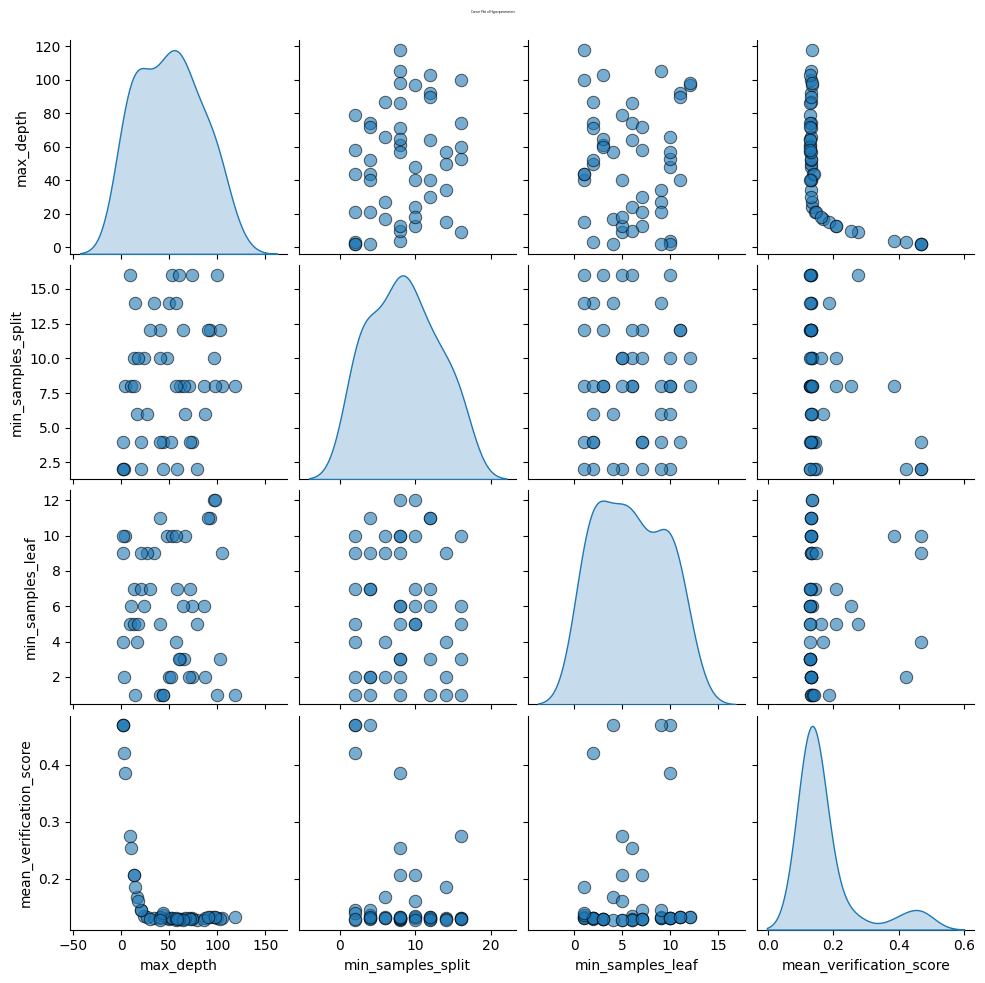

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming all_model_results_df has columns for each parameter and 'mean_verification_score'
sns.pairplot(all_model_results_df, vars=['max_depth', 'min_samples_split', 'min_samples_leaf', 'mean_verification_score'],
             diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height=2.5)
plt.suptitle('Corner Plot of Hyperparameters', size=2)
plt.subplots_adjust(top=0.95)
plt.show()


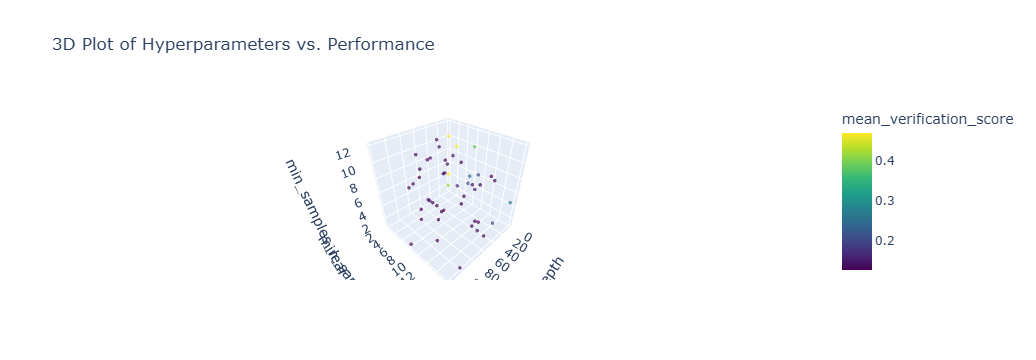

In [14]:
import plotly.express as px

# Assuming `results_df` contains 'max_depth', 'min_samples_split', 'min_samples_leaf', and 'mean_verification_score'
fig = px.scatter_3d(all_model_results_df, 
                    x='max_depth', 
                    y='min_samples_split', 
                    z='min_samples_leaf',
                    color='mean_verification_score', 
                    color_continuous_scale='Viridis', 
                    opacity=0.7,
                    title='3D Plot of Hyperparameters vs. Performance')  # Adjust size_max to make the dots smaller
fig.update_traces(marker=dict(size=2))  # Further adjust marker size if needed
fig.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming DecisionTreeTrainer is already defined and includes the train_decision_tree method

def plot_results(trials):
    # Extracting scores and plotting convergence
    scores = [-trial['result']['loss'] for trial in trials.trials]  # Adjust if necessary based on how you've stored the loss
    plt.figure(figsize=(12, 6))
    plt.plot(scores, marker='o')
    plt.grid(True)
    plt.title("Convergence over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Score (Negative MAE)")
    plt.show()

plot_results(dt_trainer.trials)


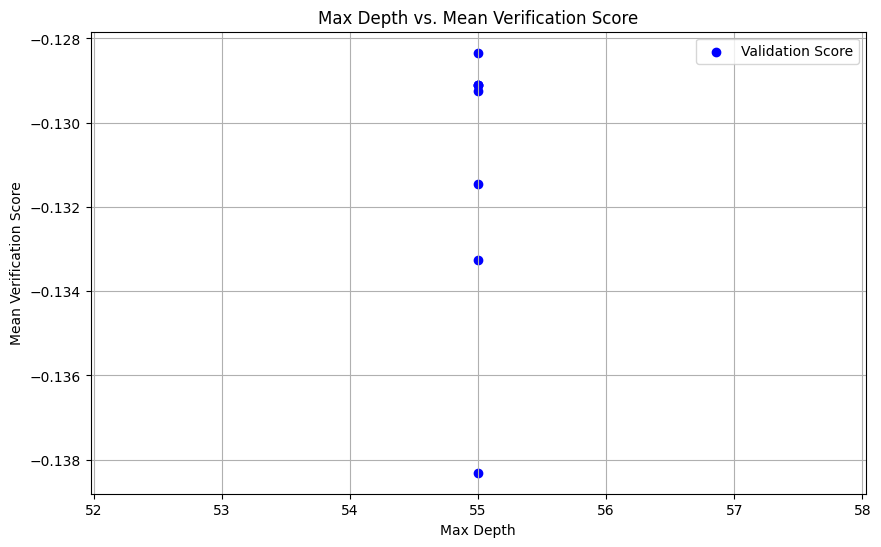

In [45]:
import matplotlib.pyplot as plt

# Assuming `results_df` is your DataFrame containing the tuning results
plt.figure(figsize=(10, 6))
plt.scatter(all_model_results_df['max_depth'], all_model_results_df['mean_verification_score'], c='blue', label='Validation Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean Verification Score')
plt.title('Max Depth vs. Mean Verification Score')
plt.legend()
plt.grid(True)
plt.show()


## <font color='red'>Visualisations are work in progress, currently not functional</font>

In [ ]:
"""
trainer.max_depth_plot(all_model_results_df, save=True, name="max_depth_plot", close=True)
trainer.mss_msl_plot(all_model_results_df, save=True, name="mss_msl_plot", close=True)
trainer.max_depth_vs_mss_plot(all_model_results_df, save=True, name="max_depth_vs_mss_plot", close=True)
trainer.max_depth_vs_msl_plot(all_model_results_df, save=True, name="max_depth_vs_msl_plot", close=True)
trainer.mss_vs_msl_plot(all_model_results_df, save=True, name="mss_vs_msl_plot", close=True) """

## <font color='green'>Independant from above, train a DT model and save the <font color='pink'>decision tree image </font></font>

In [ ]:
# importing the tree model from sklearn
from sklearn import tree

# initalizing the model instance
dt_model = tree.DecisionTreeRegressor(max_depth=80, min_samples_split=5, min_samples_leaf=4)

# training the model
dt_model.fit(x_train.values, y_train.values)

dt_model.get_depth()

In [ ]:
import random
import string
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import os

# Function to generate a random alphanumeric string of length 6
def generate_random_string(length=6):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

# Path variables
base_dir = "Figures/Tree"
rand_filename = generate_random_string() + ".png"
file_path = os.path.join(base_dir, rand_filename)

# Create the directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Get the maximum depth of the decision tree
#max_depth = dt_model.get_depth()
max_depth = 4

# Plotting the tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, max_depth=max_depth)  # Use the maximum depth of the model

# Save the plot to the specified path with higher resolution
plt.savefig(file_path, dpi=300)  # Increase DPI for higher resolution

print(f"Image saved to {file_path}")


# <font color='green'>Stop Here - Below is for Serpent2 (ace file) creation. </font>

#### U-233 Jezzebel criticality benchmark

In [ ]:
# import the ace utilities
import nucml.ace.data_utilities as ace_utils

# Import the required functions from the module
from nucml.ace.data_utilities import get_xs_for_mt, create_mt2_mt3_mt101, enforce_unitarity

In [ ]:
# Redefine the functions with necessary corrections

import os
import math
import pandas as pd

def reduce_ace_filesize(directory, keep="03c"):
    """
    Utility function to reduce the size of ACE files. Useful to remove all other information
    other than the section of interest (i.e. .03c).

    Args:
        directory (str): Path to directory where all ACE files will be searched and processed.
        keep (str, optional): Temperature to keep. Must not include the dot. Defaults to "03c".

    Returns:
        None

    Corrected to check line length before accessing the 10th character to avoid IndexError.
    """
    all_ace_files = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".ace"):
                all_ace_files.append(os.path.abspath(os.path.join(root, file)))

    for i in all_ace_files:
        tags = []
        final_tags = []
        new_file_lines = []

        with open(i) as infile:
            for line in infile:
                # Check if the line has at least 10 characters to avoid IndexError
                if len(line) > 9 and line[9] == "c":
                    tags.append(line[:10])

        for t in tags:
            if t.endswith(keep):
                continue
            else:
                final_tags.append(t)

        with open(i, 'r') as infile:
            flag = False
            for line in infile:
                if line[7:10] == keep:
                    flag = True
                if flag:
                    new_file_lines.append(line)
                if line[:10] in final_tags:
                    flag = False

        with open(i, "w") as outfile:
            outfile.writelines(new_file_lines)

        ace_utils.convert_dos_to_unix(i)
    return None


def parsing_datatypes(x):
    """
    Utility function to correctly format numbers before writing them to new .ACE files.

    Parameters:
    x: The value to be formatted.

    Returns:
        float: Formatted value.

    Corrected to handle infinity values properly.
    """
    if math.isnan(x):
        return ""  # Return an empty string for NaN values
    elif math.isinf(x):
        if x > 0:
            return "{:20.12E}".format(1e+99)  # Use a large number for positive infinity
        else:
            return "{:20.12E}".format(-1e+99)  # Use a large negative number for negative infinity
    elif x - int(x) == 0:
        return "{:20}".format(int(x))  # Format integers
    else:
        return "{:20.12E}".format(x)  # Format floats


def get_final_ml_ace_df(energies, mt_array, mt_xs_pointers_array, pointers, jxs_df, xss, ml_df, ml_list=["MT_1", "MT_2", "MT_3", "MT_18", "MT_101", "MT_102"]):
    """Given a set of ML generated XS (adjusted), this function allows to fill in other reaction channels not included
    by the ML predictions. This is useful since for some calculations some MT reactions are not required but are still present
    in the ACE files. This allows to preserve the ACE file values and structure.

    For MT3 the ML generated cross sections are adjusted so that conservation rules are not broken. Same for MT101.
    All values will be at the energy grid specified by the energies array.

    Note: MT2 is not calculated here.

    TODO: DEAL WITH MT3 BETTER IN CASE IT IS GENERATED BY ML, WHAT ELSE TO ADJUST

    Returns:
        DataFrame: DataFrame containing the resulting cross sections from both ML and ACE.
    """

    """
    Generate the final ACE DataFrame with machine learning cross-sections.

    Parameters:
    energies (array): Array of energy values.
    mt_array (array): Array of MT values.
    mt_xs_pointers_array (array): Pointers to the XS values.
    pointers (dict): Dictionary of pointers.
    jxs_df (DataFrame): DataFrame of JXS values.
    xss (array): Array of XSS values.
    ml_df (DataFrame): DataFrame of machine learning predictions.
    ml_list (list): List of MT columns to include.

    Corrected to check if each MT exists in ml_df before accessing it.
    """
    Energy_Grid = pd.DataFrame({"Energy": energies})
    Energy_Grid = Energy_Grid.set_index("Energy")

    for i in mt_array:
        mt_info = get_xs_for_mt(i, mt_array, mt_xs_pointers_array, jxs_df, xss, pointers)
        to_add = pd.DataFrame({"Energy": mt_info["energy"], "MT_" + str(int(i)): mt_info["xs"]})
        to_add = to_add.set_index("Energy")
        Energy_Grid = pd.merge(Energy_Grid, to_add, left_index=True, right_index=True, how="outer")
    Energy_Grid = Energy_Grid.fillna(value=0)

    for i in ml_list:
        if i in ml_df.columns:
            Energy_Grid[i] = ml_df[i].values
        else:
            print(f"Warning: {i} not found in ml_df.columns")

    Energy_Grid = create_mt2_mt3_mt101(Energy_Grid, mt_array)
    Energy_Grid = enforce_unitarity(Energy_Grid)
    return Energy_Grid

# Override the functions in the module
ace_utils.reduce_ace_filesize = reduce_ace_filesize
ace_utils.parsing_datatypes = parsing_datatypes
ace_utils.get_final_ml_ace_df = get_final_ml_ace_df




def get_nxs_jxs_xss(isotope, temp="03c", custom_path=None, reduced=False):
    """
    Retrieves the NSX, JXS, and XSS tables for a given isotope at a given temperature.
    The JSX DataFrame indicates the indices to the XSS where different pieces of data begin.
    The XSS table contains the actual data needed by many functions of the ACE utilities.

    Args:
        isotope (str): Isotope in ZZAAA format.
        temp (str, optional): Temperature in ace format (i.e. 03c means 300C). Defaults to "03c".
        custom_path (str, optional): File-path to a new ACE file not stored in the configured ACE directory. Defaults to None.

    Returns:
        (tuple): tuple containing:
            nxs (DataFrame)
            jxs (DataFrame)
            xss (np.array)
    """
    path, to_skip, lines = ace_utils.get_to_skip_lines(isotope, temp=temp)
    if (path != None) and (custom_path != None):
        if reduced:
            to_skip = 0

        nxs = pd.read_csv(custom_path, sep=r'\s+', skiprows=to_skip+6, nrows=2, header=None)
        jxs = pd.read_csv(custom_path, sep=r'\s+', skiprows=to_skip+8, nrows=4, header=None)
        xss = pd.read_csv(custom_path, sep=r'\s+', skiprows=to_skip+12, nrows=lines, header=None).values.flatten()
        return nxs, jxs, xss
    elif path != None:
        nxs = pd.read_csv(path, sep=r'\s+', skiprows=to_skip+6, nrows=2, header=None)
        jxs = pd.read_csv(path, sep=r'\s+', skiprows=to_skip+8, nrows=4, header=None)
        xss = pd.read_csv(path, sep=r'\s+', skiprows=to_skip+12, nrows=lines, header=None).values.flatten()
        return nxs, jxs, xss

ace_utils.get_nxs_jxs_xss = get_nxs_jxs_xss

In [ ]:
# seems as though we no longer require this (small fix for small data sets)

def enforce_unitarity(ml_ace_df):
    """Creates MT2 XS and adjusts MT1 accordingly.

    Calculates MT2 by subtracting MT3 from MT1. If MT2 is negative:
    - Replace negatives with NaN
    - Interpolates from closest values
    - Adds back amount to MT1 to conserve XS.

    Args:
        ml_ace_df (DataFrame): DataFrame containing the original MT1, MT2, and MT3.

    Returns:
        DataFrame: returns an adjusted dataframe.
    """
    # Ensure the necessary columns exist
    if 'MT_1' in ml_ace_df.columns and 'MT_3' in ml_ace_df.columns:
        # Print the data types before conversion
        print("Data types in MT_1 before conversion:")
        print(ml_ace_df['MT_1'].apply(type).value_counts())

        print("Data types in MT_3 before conversion:")
        print(ml_ace_df['MT_3'].apply(type).value_counts())

        # Convert columns to numeric, coercing errors to NaN
        ml_ace_df['MT_1'] = pd.to_numeric(ml_ace_df['MT_1'], errors='coerce')
        ml_ace_df['MT_3'] = pd.to_numeric(ml_ace_df['MT_3'], errors='coerce')

        adjusting_mt1 = pd.DataFrame({"MT_1": ml_ace_df.MT_1.values, "MT_3": ml_ace_df.MT_3.values})
        adjusting_mt1["MT_2"] = adjusting_mt1.MT_1.values - adjusting_mt1.MT_3.values

        # Count invalid values (NaN or infinity) in the result
        invalid_count = np.sum(np.isnan(adjusting_mt1["MT_2"]) | np.isinf(adjusting_mt1["MT_2"]))
        print(f"Number of invalid rows in MT_2: {invalid_count}")

        # Count NaNs and infinities separately
        nan_count = np.sum(np.isnan(adjusting_mt1["MT_2"]))
        inf_count = np.sum(np.isinf(adjusting_mt1["MT_2"]))
        print(f"Number of NaNs in MT_2: {nan_count}")
        print(f"Number of infinities in MT_2: {inf_count}")

        # Replace negatives with NaN, interpolate and adjust MT_1 accordingly
        adjusting_mt1["MT_2"] = adjusting_mt1["MT_2"].apply(lambda x: x if x > 0 else -1)
        adjusting_mt1 = adjusting_mt1.replace(to_replace=-1, value=np.nan)
        adjusting_mt1 = adjusting_mt1.interpolate()
        adjusting_mt1["MT_1_int"] = adjusting_mt1["MT_2"] + adjusting_mt1["MT_3"]
        adjusting_mt1["MT_1_to_add"] = adjusting_mt1["MT_1_int"] - adjusting_mt1["MT_1"]
        adjusting_mt1["MT_1_Final"] = adjusting_mt1["MT_1"] + adjusting_mt1["MT_1_to_add"]

        ml_ace_df["MT_1"] = adjusting_mt1["MT_1_Final"].values
        ml_ace_df["MT_2"] = adjusting_mt1["MT_2"].values

        # Print the data types after conversion
        print("Data types in MT_1 after conversion:")
        print(ml_ace_df['MT_1'].apply(type).value_counts())

        print("Data types in MT_3 after conversion:")
        print(ml_ace_df['MT_3'].apply(type).value_counts())

        return ml_ace_df
    else:
        print("Required columns MT_1 or MT_3 are missing in the DataFrame.")
        return ml_ace_df


In [ ]:
# 1) specify directory where all benchmark files will be created
dt_ml_ace_dir = "DT_B0/"

#print(working_directory)
# Modify the data_utilities module to use the correct path
template_dir = os.path.join(working_directory, 'ML_Nuclear_Data/Benchmarks/inputs/templates')
#print(f"Template directory: {template_dir}")

# 6) Define the ACE directory path
#ace_dir = os.path.join(working_directory, 'ML_Nuclear_Data/acedata')
#print(ace_dir)

# 2) Use the dt_results dataframe to generate benchmark files
ace_utils.generate_bench_ml_xs(data, dt_results, "U233_MET_FAST_001", to_scale, dt_ml_ace_dir, template_dir=template_dir)

In [ ]:
# Generate a bash script that will allow us to run all benchmark input files
script_name = "serpent_bash_script"

ace_utils.generate_serpent_bash(dt_ml_ace_dir, script_name)

predicting_nuclear_xs_v2 - ARGS - model type - normalization - FIXED

https://pypi.org/project/transparency/

## Boosted Decision Tree class

In [5]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from joblib import dump
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

class BoostedDecisionTreeTrainer:
    def __init__(self, x_train, y_train, x_test, y_test, scaler=None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.scaler = scaler
        self.best_model = None

    def create_param_grid(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step, min_lr, max_lr, lr_step):
        param_grid = {
            'max_depth': range(min_depth, max_depth + 1, depth_step),
            'min_samples_split': range(min_mss, max_mss + 1, mss_step),
            'min_samples_leaf': range(min_msl, max_msl + 1, msl_step),
            'learning_rate': [min_lr + i * lr_step for i in range(int((max_lr - min_lr) / lr_step) + 1)]
        }
        return param_grid

    def train_boosted_decision_tree(self, min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step, min_lr, max_lr, lr_step, cv, n_jobs, verbose, scoring):
        param_grid = self.create_param_grid(min_depth, max_depth, depth_step, min_mss, max_mss, mss_step, min_msl, max_msl, msl_step, min_lr, max_lr, lr_step)
        
        grid_search = HalvingGridSearchCV(
            estimator=GradientBoostingRegressor(),
            param_grid=param_grid,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            scoring=scoring,
            return_train_score=True
        )

        start_time = time.time()
        grid_search.fit(self.x_train, self.y_train)
        end_time = time.time()
        training_time = end_time - start_time

        self.best_model = grid_search.best_estimator_
        cv_results = pd.DataFrame(grid_search.cv_results_)

        all_model_results = []
        for i, params in enumerate(cv_results['params']):
            row = {
                'Parameters': params,
                'Train MAE': -cv_results['mean_train_score'][i],
                'CV MAE': -cv_results['mean_test_score'][i],  # Renamed from 'Test MAE' to 'CV MAE'
                'Training Time (s)': training_time,
                'mean_fit_time': cv_results['mean_fit_time'][i],
                'std_fit_time': cv_results['std_fit_time'][i],
                'mean_score_time': cv_results['mean_score_time'][i],
                'std_score_time': cv_results['std_score_time'][i],
                'split0_cv_score': -cv_results['split0_test_score'][i],
                'split1_cv_score': -cv_results['split1_test_score'][i],
                'split2_cv_score': -cv_results['split2_test_score'][i] if 'split2_test_score' in cv_results else None,
                'split3_cv_score': -cv_results['split3_test_score'][i] if 'split3_test_score' in cv_results else None,
                'split4_cv_score': -cv_results['split4_test_score'][i] if 'split4_test_score' in cv_results else None,
                'mean_cv_score': -cv_results['mean_test_score'][i],  # Renamed from 'mean_test_score' to 'mean_cv_score'
                'std_cv_score': cv_results['std_test_score'][i],  # Renamed from 'std_test_score' to 'std_cv_score'
                'rank_cv_score': cv_results['rank_test_score'][i],  # Renamed from 'rank_test_score' to 'rank_cv_score'
                'split0_train_score': -cv_results['split0_train_score'][i],
                'split1_train_score': -cv_results['split1_train_score'][i],
                'split2_train_score': -cv_results['split2_train_score'][i] if 'split2_train_score' in cv_results else None,
                'split3_train_score': -cv_results['split3_train_score'][i] if 'split3_train_score' in cv_results else None,
                'split4_train_score': -cv_results['split4_train_score'][i] if 'split4_train_score' in cv_results else None,
                'mean_train_score': -cv_results['mean_train_score'][i],
                'std_train_score': cv_results['std_train_score'][i],
            }
            all_model_results.append(row)

        all_model_results_df = pd.DataFrame(all_model_results)
        
        # Evaluate the best model on the separate test set using MAE
        test_predictions = self.best_model.predict(self.x_test)
        test_score = mean_absolute_error(self.y_test, test_predictions)
        print("Final Test set MAE: ", test_score)

        return grid_search.best_params_, cv_results, all_model_results_df, test_score

    def save_model_and_results(self, save_dir, model_name="best_gbt_model.joblib"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        model_saving_path = os.path.join(save_dir, model_name)
        scaler_saving_path = os.path.join(save_dir, 'scaler.pkl') if self.scaler else None

        dump(self.best_model, model_saving_path)
        if self.scaler:
            dump(self.scaler, open(scaler_saving_path, 'wb'))

        return model_saving_path, scaler_saving_path

    def save_results(self, results_dir, model_saving_path, scaler_saving_path, all_model_results_df, test_score):
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        best_gbt_results = {
            "model_path": model_saving_path,
            "scaler_path": scaler_saving_path if scaler_saving_path else "None",
            "Parameters": self.best_model.get_params(),
            "mean_train_score": -all_model_results_df["mean_train_score"].min(),
            "mean_cv_score": -all_model_results_df["mean_cv_score"].min(),  # Renamed from 'mean_test_score' to 'mean_cv_score'
            "Test set score": test_score,  # Added real test score
            "Training Time (s)": all_model_results_df["Training Time (s)"].iloc[0]
        }

        best_gbt_results_df = pd.DataFrame([best_gbt_results])
        best_gbt_results_filepath = os.path.join(results_dir, 'best_bgt_results.csv')
        best_gbt_results_df.to_csv(best_gbt_results_filepath, index=False)

        all_gbt_results_filepath = os.path.join(results_dir, 'all_bgt_results.csv')
        all_model_results_df.to_csv(all_gbt_results_filepath, index=False)

        return best_gbt_results_filepath, all_gbt_results_filepath


#### Train a Boosted Decision Tree (<font color='pink'>enter custom parameter space</font>)

In [ ]:
# Example usage:
trainer = BoostedDecisionTreeTrainer(x_train.values, y_train.values, x_test.values, y_test.values, scaler=None)
best_params, cv_results, all_model_results_df, test_score = trainer.train_boosted_decision_tree(
    min_depth=30, max_depth=30, depth_step=1,
    min_mss=8, max_mss=8, mss_step=1,
    min_msl=10, max_msl=10, msl_step=1,
    min_lr=0.05, max_lr=0.05, lr_step=0.01,
    cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error'
)

# Create a string for model name based on data parameters
model_name_suffix = f"mode={mode}_log={log}_lowen={low_en}_maxen={max_en}_num={num}_basic={basic}_filters={filters}_normalize={normalize}"
model_name_suffix = model_name_suffix.replace("=", "-").replace(".", "p")
model_name = f"best_bdt_model_{model_name_suffix}" 

# save the model
model_saving_path, scaler_saving_path = dt_trainer.save_model_and_results('models/save', model_string=model_name)
results_filepath, all_model_results_filepath = dt_trainer.save_results('models/results', model_saving_path, scaler_saving_path, all_model_results_df, test_score)

print(f"Model saved to: {model_saving_path}")

"""
trainer.max_depth_plot(all_model_results_df, save=True, name="max_depth_plot", close=True)
trainer.mss_msl_plot(all_model_results_df, save=True, name="mss_msl_plot", close=True)
trainer.max_depth_vs_mss_plot(all_model_results_df, save=True, name="max_depth_vs_mss_plot", close=True)
trainer.max_depth_vs_msl_plot(all_model_results_df, save=True, name="max_depth_vs_msl_plot", close=True)
trainer.mss_vs_msl_plot(all_model_results_df, save=True, name="mss_vs_msl_plot", close=True) 
"""


#### XGBOOST (NVIDIA)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Correctly setting the parameters
params = {
    'max_depth': 10,
    'min_child_weight': 1,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # Use 'hist' for histogram-based method
    'device': 'cuda',  # Explicitly setting device to 'cuda' for GPU
}

# Creating the DMatrix data format for XGBoost which is optimized for both memory efficiency and training speed
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test, label=y_test)

# Initialize the XGBRegressor with the updated parameters
model = xgb.XGBRegressor(**params)

# Fitting the model
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='mae', early_stopping_rounds=10)

# Predict and evaluate
predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

        return cv_results, mae

    def save_model(self, filename):
        """ Saves the best model to a file. """
        self.best_model.save_model(filename)
        print(f"Model saved to {filename}")

# Example usage:
trainer = BoostedDecisionTreeTrainer(x_train, y_train, x_test, y_test)
params = {
    'max_depth': 10,
    'min_child_weight': 1,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # Updated to 'hist'
    'device': 'cuda'  # Specifying to use GPU
}

trainer = BoostedDecisionTreeTrainer(x_train, y_train, x_test, y_test)
cv_results, test_mae = trainer.train_boosted_decision_tree(params, num_boost_round=1000, nfold=3, early_stopping_rounds=50)
trainer.save_model('best_xgbt_model.json')


In [1]:
data.head()

NameError: name 'data' is not defined